In [291]:
#imports!

import pandas as pd
import numpy as np


from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


import matplotlib.pyplot as plt
import seaborn as sns


In [292]:
# load dataset from here:  https://archive.ics.uci.edu/dataset/222/bank+marketing
df=pd.read_csv('Downloads/bank+marketing/bank/bank-full.csv',sep=';')

In [293]:
# several object types to convert to numerical data for modeling
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [294]:
#Convert binary categorical features to a numerical form
df['default']=df.default.map(dict(yes=1,no=0))
df['housing']=df.housing.map(dict(yes=1,no=0))
df['loan']=df.loan.map(dict(yes=1,no=0))
df['y']=df.y.map(dict(yes=1,no=0))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [295]:
# Blend cellular and telephone to establish a binary
# Change contact to a numerical type.  
df['contact']=df.contact.map(dict({'cellular':1,'unknown':0,'telephone':1}))
df['contact'].value_counts()

1    32191
0    13020
Name: contact, dtype: int64

In [296]:
#Convert months from string to int
df['month']=df.month.map(dict({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,0,5,5,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,0,5,5,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,0,5,5,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,0,5,5,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,0,5,5,198,1,-1,0,unknown,0


In [297]:
# change previous outcome poutcome to numerical.  
df['poutcome']=df.poutcome.map(dict({'failure':-1,'unknown':0,'other':0,'success':1}))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,0,5,5,261,1,-1,0,0,0
1,44,technician,single,secondary,0,29,1,0,0,5,5,151,1,-1,0,0,0
2,33,entrepreneur,married,secondary,0,2,1,1,0,5,5,76,1,-1,0,0,0
3,47,blue-collar,married,unknown,0,1506,1,0,0,5,5,92,1,-1,0,0,0
4,33,unknown,single,unknown,0,1,0,0,0,5,5,198,1,-1,0,0,0


In [298]:
# Change education and marital to numerical object types
df['education']=df.education.map(dict({'unknown':0,'primary':1,'secondary':2,'tertiary':3}))
df['marital']=df.marital.map(dict({'single':0,'married':1,'divorced':-1}))
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,1,3,0,2143,1,0,0,5,5,261,1,-1,0,0,0
1,44,technician,0,2,0,29,1,0,0,5,5,151,1,-1,0,0,0
2,33,entrepreneur,1,2,0,2,1,1,0,5,5,76,1,-1,0,0,0
3,47,blue-collar,1,0,0,1506,1,0,0,5,5,92,1,-1,0,0,0
4,33,unknown,0,0,0,1,0,0,0,5,5,198,1,-1,0,0,0


In [299]:
# Build training and test datasets for modeling.  Drop job bc it is categorical.  
# Will use groups later to explore jobs impact on results
X=df.drop(['y','job'],axis=1)
y=df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [300]:
# fairly imbalanced dataset at 89% 'no'.  Consider oversampling if models are not productive.
y.value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [301]:
# Methodology:
# Create pipes for each algorithm that scale and fit a model against train data
# Measure precision for each algorithm to establish best model and to tune parameters
# Use feature weights from each algorithm to identify potential cohorts that will optimize distribution of 'y' 
# Measure the % 'y' of different cohorts within the original dataset to drive insights and actions
# Note that parameter optimization is included in the appendix, but commented out bc it is process intensive

In [302]:
# GridSearch optimized for precision determined optimal n_neighbors to be 5.  See code in Appendix for more detail.
# Note that Gridsearches take a long time to run.  Uncomment them if you want to run them yourself.
%time
pipe_knn=Pipeline([('scale',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=26))])
pipe_knn.fit(X_train,y_train)
preds_knn=pipe_knn.predict(X_test)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [303]:
%%time
pipe_lr=Pipeline([('scale',StandardScaler()),('lr',LogisticRegression())])
pipe_lr.fit(X_train,y_train)
preds_lr=pipe_lr.predict(X_test)

CPU times: user 289 ms, sys: 15.8 ms, total: 305 ms
Wall time: 66.5 ms


In [304]:
%%time
pipe_dt=Pipeline([('scale',StandardScaler()),('dt',DecisionTreeClassifier())])
pipe_dt.fit(X_train,y_train)
preds_dt=pipe_dt.predict(X_test)

CPU times: user 152 ms, sys: 4.62 ms, total: 156 ms
Wall time: 161 ms


In [305]:
%%time
pipe_svc=Pipeline([('scale',StandardScaler()),('svc',SVC(C=5))])
pipe_svc.fit(X_train,y_train)
preds_svc=pipe_svc.predict(X_test)

CPU times: user 24.3 s, sys: 183 ms, total: 24.5 s
Wall time: 24.6 s


In [306]:
df_precision=pd.DataFrame(columns=('Model','Precision_Score_%'))
df_precision.loc[len(df_precision)]=('SVC',int(100*precision_score(y_test,preds_svc)))
df_precision.loc[len(df_precision)]=('Logistic_Regression',int(100*precision_score(y_test,preds_lr)))
df_precision.loc[len(df_precision)]=('K_Nearest_Neighbor',int(100*precision_score(y_test,preds_knn)))
df_precision.loc[len(df_precision)]=('Decision_Tree',int(100*precision_score(y_test,preds_dt)))



df_precision.head()

,Model,Precision_Score_%
0,SVC,63
1,Logistic_Regression,62
2,K_Nearest_Neighbor,65
3,Decision_Tree,46


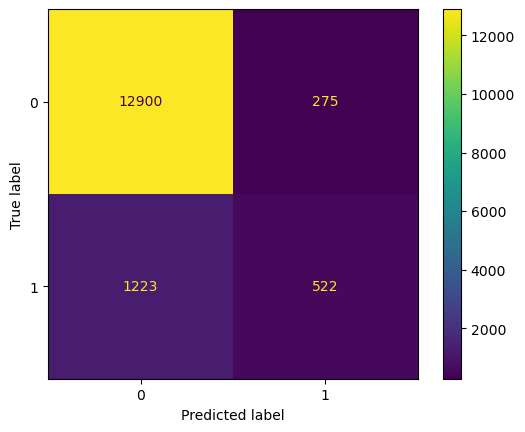

In [307]:
# Further visualizations of the results
cm_knn=confusion_matrix(y_test,preds_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot()

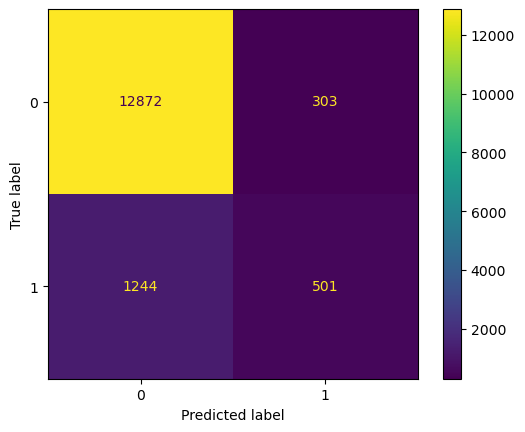

In [308]:
cm_lr=confusion_matrix(y_test,preds_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot()

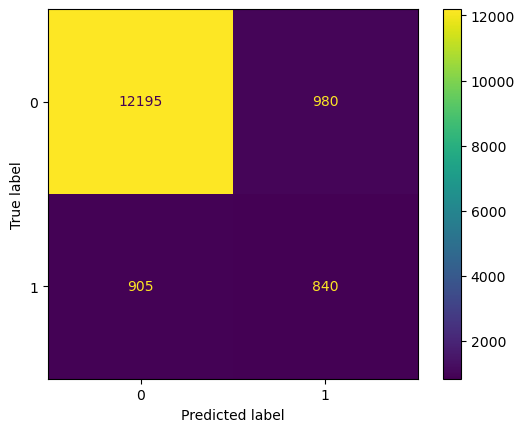

In [309]:
cm_dt=confusion_matrix(y_test,preds_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp.plot()

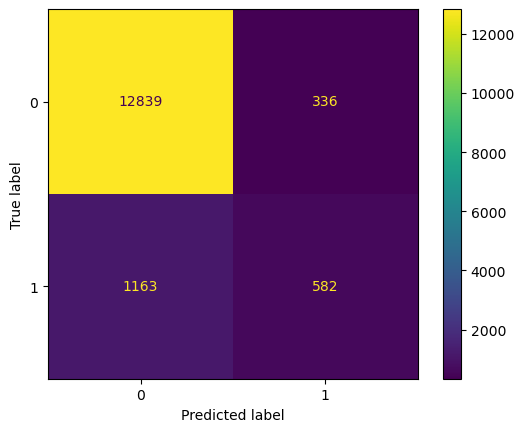

In [310]:
cm_svc=confusion_matrix(y_test,preds_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp.plot()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs


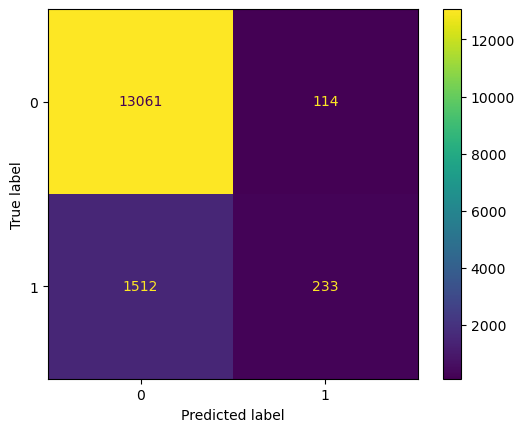

In [311]:
# Use SVC with linear regression so that we can derive feature weights
%time
pipe_svc_lr=Pipeline([('scale',StandardScaler()),('svc_lr',SVC(kernel='linear',C=5))])
pipe_svc_lr.fit(X_train,y_train)
preds_svc_lr=pipe_svc_lr.predict(X_test)
cm_svc_lr=confusion_matrix(y_test,preds_svc_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_lr)
disp.plot()

CPU times: user 16.3 s, sys: 134 ms, total: 16.4 s
Wall time: 16.4 s


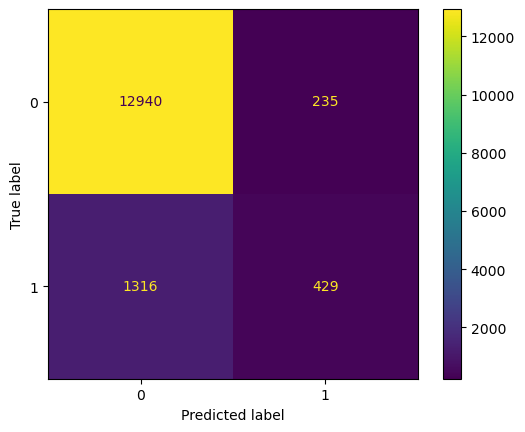

In [312]:
%%time
pipe_svc_poly=Pipeline([('scale',StandardScaler()),('svc_poly',SVC(kernel='poly'))])
pipe_svc_poly.fit(X_train,y_train)
preds_svc_poly=pipe_svc_poly.predict(X_test)
cm_svc_poly=confusion_matrix(y_test,preds_svc_poly)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc_poly)
disp.plot()

In [313]:
df_precision=pd.DataFrame(columns=('Model','Precision_Score_%'))
df_precision.loc[len(df_precision)]=('SVC',int(100*precision_score(y_test,preds_svc)))
df_precision.loc[len(df_precision)]=('Logistic_Regression',int(100*precision_score(y_test,preds_lr)))
df_precision.loc[len(df_precision)]=('K_Nearest_Neighbor',int(100*precision_score(y_test,preds_knn)))
df_precision.loc[len(df_precision)]=('Decision_Tree',int(100*precision_score(y_test,preds_dt)))
df_precision.loc[len(df_precision)]=('SVC_lr',int(100*precision_score(y_test,preds_svc_lr)))
df_precision.loc[len(df_precision)]=('SVC_poly',int(100*precision_score(y_test,preds_svc_poly)))
df_precision=df_precision.sort_values(by='Precision_Score_%')


df_precision.head(10)

,Model,Precision_Score_%
3,Decision_Tree,46
1,Logistic_Regression,62
0,SVC,63
5,SVC_poly,64
2,K_Nearest_Neighbor,65
4,SVC_lr,67


In [314]:
# Test run to ensure coef_ look sane
print(pipe_knn.named_steps.knn.weights,'\n')  # KNN does not have a numerical method for feature importance
print(pipe_lr.named_steps.lr.coef_,'\n')
print(pipe_dt.named_steps.dt.feature_importances_,'\n')
print(pipe_svc_lr.named_steps.svc_lr.coef_,'\n')

uniform 

[[ 0.03314937 -0.11904886  0.1313086  -0.03267785  0.05527678 -0.45794359
  -0.23638935  0.60755117 -0.03289361 -0.02878567  1.03785855 -0.42882605
   0.34481068  0.13331141  0.46417372]] 

[0.1020131  0.02045675 0.0248423  0.00187612 0.13142921 0.01501786
 0.00733415 0.01681708 0.09744301 0.08010472 0.29863087 0.03559729
 0.05489613 0.01755781 0.09598362] 

[[ 0.02470352 -0.02552545  0.0351482  -0.008227    0.01138382 -0.12013715
  -0.06760075  0.13946942 -0.00408879  0.00445649  0.32997048 -0.10257084
   0.1359816   0.03309873  0.23382416]] 



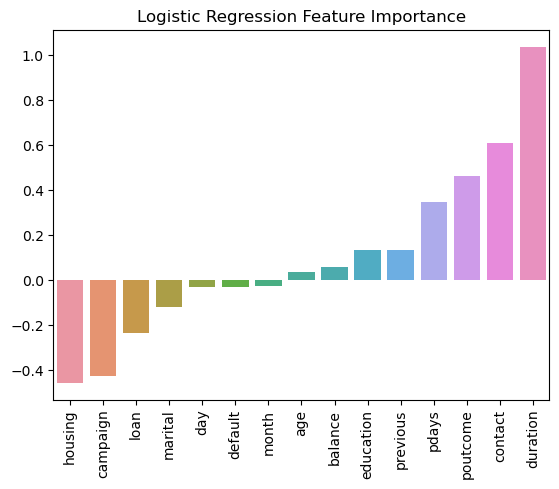

In [315]:
#print(pipe_lr.named_steps.scale.get_feature_names_out())
df_lr_features=pd.DataFrame(pipe_lr.named_steps.lr.coef_,columns=pipe_lr.named_steps.scale.get_feature_names_out())
df_lr_features=df_lr_features.sort_values(by=0, ascending=True, axis=1)
df_lr_features.head()
sns.barplot(data=df_lr_features).set(title='Logistic Regression Feature Importance')
plt.xticks(rotation=90);

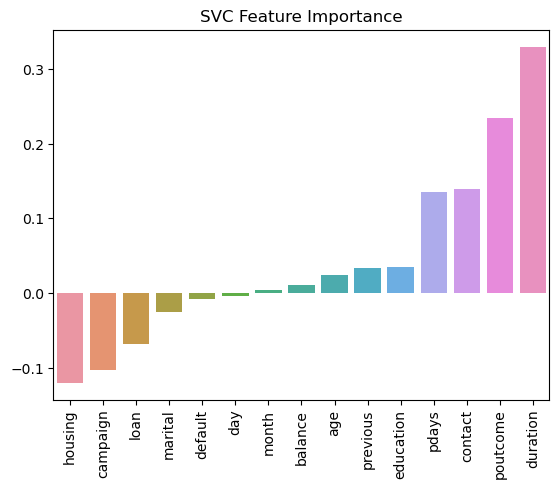

In [316]:
#print(pipe_lr.named_steps.scale.get_feature_names_out())
df_svc_features=pd.DataFrame(pipe_svc_lr.named_steps.svc_lr.coef_,columns=pipe_svc_lr.named_steps.scale.get_feature_names_out())
df_svc_features=df_svc_features.sort_values(by=0, ascending=True, axis=1)
df_svc_features.head()
sns.barplot(data=df_svc_features).set(title='SVC Feature Importance')
plt.xticks(rotation=90);

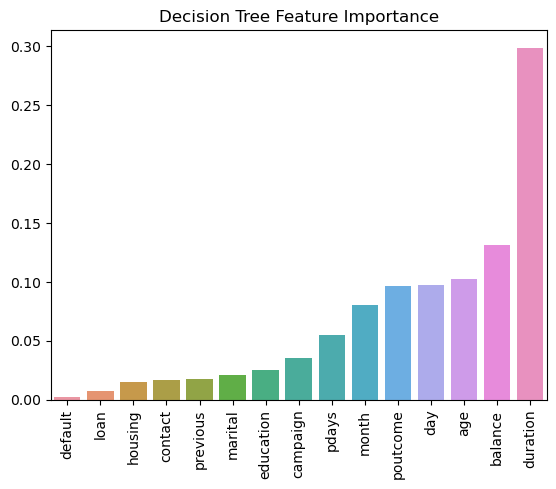

In [317]:
df_dt_features=pd.DataFrame(columns=pipe_dt.named_steps.scale.get_feature_names_out())
df_dt_features.loc[len(df_dt_features)] = pipe_dt.named_steps.dt.feature_importances_
df_dt_features=df_dt_features.sort_values(by=0, ascending=True, axis=1)
df_dt_features.head()
sns.barplot(data=df_dt_features).set(title='Decision Tree Feature Importance')
plt.xticks(rotation=90);

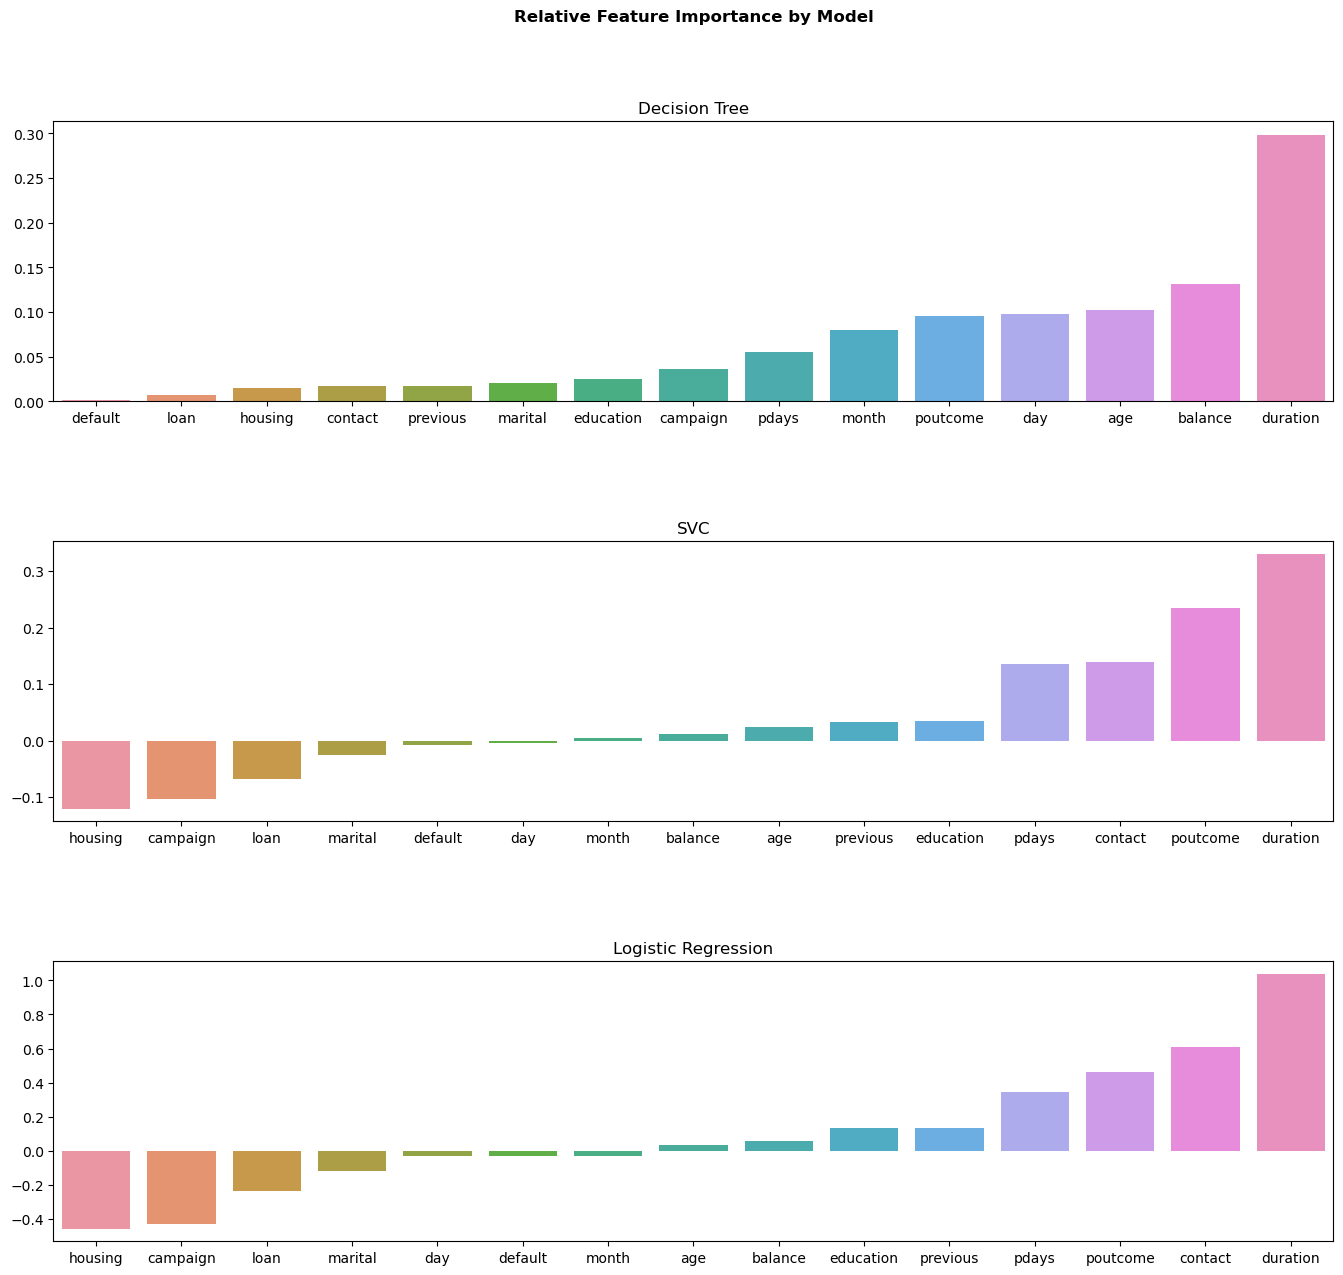

In [318]:
# combine all feature plots
fig, axs = plt.subplots(figsize=(16, 14),nrows=3)
sns.barplot(data=df_dt_features,ax=axs[0])
sns.barplot(data=df_svc_features,ax=axs[1]).set(title='SVC')
sns.barplot(data=df_lr_features,ax=axs[2]).set(title='Logistic Regression')
axs[0].set(title='Decision Tree')
plt.suptitle("Relative Feature Importance by Model",fontweight='bold')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.5,
                    hspace=0.5)

plt.savefig('/var/local/data/bank_loan_predictor/images/Relative_Feature_Importance.png')
plt.show();
#plt.tight_layout(pad=5.0)
#plt.xticks(rotation=90);

In [319]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,1,3,0,2143,1,0,0,5,5,261,1,-1,0,0,0
1,44,technician,0,2,0,29,1,0,0,5,5,151,1,-1,0,0,0
2,33,entrepreneur,1,2,0,2,1,1,0,5,5,76,1,-1,0,0,0
3,47,blue-collar,1,0,0,1506,1,0,0,5,5,92,1,-1,0,0,0
4,33,unknown,0,0,0,1,0,0,0,5,5,198,1,-1,0,0,0


In [320]:
#Explore Conversion rates by binary variables
# Because they are binary, mean represents their relative conversion rates
# Note that previous outcome is the strongest indicator at 64.7%

print(df.groupby(['marital'])['y'].mean())
print(df.groupby(['poutcome'])['y'].mean())
print(df.groupby(['education'])['y'].mean())
print(df.groupby(['housing'])['y'].mean())
print(df.groupby(['contact'])['y'].mean())
print(df.groupby(['poutcome'])['y'].mean())


marital
-1    0.119455
 0    0.149492
 1    0.101235
Name: y, dtype: float64
poutcome
-1    0.126097
 0    0.095183
 1    0.647253
Name: y, dtype: float64
education
0    0.135703
1    0.086265
2    0.105594
3    0.150064
Name: y, dtype: float64
housing
0    0.167024
1    0.077000
Name: y, dtype: float64
contact
0    0.040707
1    0.147836
Name: y, dtype: float64
poutcome
-1    0.126097
 0    0.095183
 1    0.647253
Name: y, dtype: float64


In [321]:
# Find split for each continous feature, plan to use the midpoint between two numbers to optimize results
# will use > 40 for age
# will use 1300 for balance
# will use 220 for duration
print(df.groupby(['y'])['age'].mean())
print(df.groupby(['y'])['balance'].mean())
print(df.groupby(['y'])['duration'].mean())
print(df['duration'].mean())

y
0    40.838986
1    41.670070
Name: age, dtype: float64
y
0    1303.714969
1    1804.267915
Name: balance, dtype: float64
y
0    221.182806
1    537.294574
Name: duration, dtype: float64
258.1630797814691


In [322]:
# Build a dataframe to plot conversion rate by job
# Note that students and retirees have the highest conversion rates
df_jobs=pd.DataFrame(df.groupby('job')['y'].mean())
df_jobs=df_test.reset_index()
df_jobs['y']=round(df_jobs['y']*100,1)
df_jobs = df_jobs.rename(columns={'y': 'Conversion_%','job':'Job'})
df_jobs=df_jobs.sort_values(by='Conversion_%')
df_jobs.head()



,index,Job,Conversion_%
1,1,blue-collar,7.3
2,2,entrepreneur,8.3
3,3,housemaid,8.8
7,7,services,8.9
9,9,technician,11.1


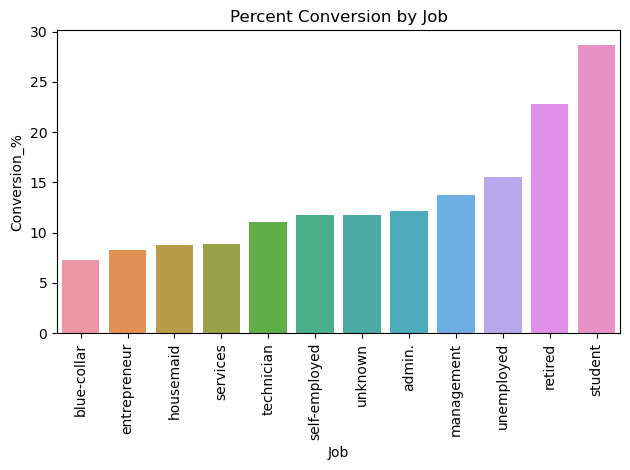

In [323]:
sns.barplot(data=df_jobs, x='Job',y='Conversion_%').set(title='Percent Conversion by Job')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/var/local/data/bank_loan_predictor/images/Conversion_By_Job.jpg')
plt.show();

In [327]:
# Start exploring cohorts that we can assemble to provide high value targets for the sales team
job_cohort=('retired','student')
job_cohort_df=df.query('job.isin(@job_cohort)')
print('job_cohort mean:',job_cohort_df['y'].mean(),'/n')
print('original mean:',df['y'].mean(),'/n')

job_cohort mean: 0.24515927545284197 /n
original mean: 0.11698480458295547 /n


In [328]:
po_cohort_df=df.query('poutcome == 1 ')
print('po_cohort mean:',po_cohort_df['y'].mean(),'/n')
print('original mean:',df['y'].mean(),'/n')

po_cohort mean: 0.6472534745201853 /n
original mean: 0.11698480458295547 /n


In [329]:
results_df.head()

,Cohort,Percent_Conversion
3,Large Balance Cohort,15.8
4,Housing Cohort,16.7
1,Long Duration Cohort,22.9
2,Student Cohort,28.7
0,Repeat Customer Cohort,64.7


In [330]:
duration_cohort_df=df.query('duration > 220')
print('duration cohort mean:',duration_cohort_df['y'].mean(),'/n')

duration cohort mean: 0.22932721211127507 /n


In [331]:
student_cohort_df=df.query('job == "student"')
print('student cohort mean:',student_cohort_df['y'].mean(),'/n')

student cohort mean: 0.2867803837953092 /n


In [332]:
balance_cohort_df=df.query('balance > 1300')
print('balance cohort mean:',balance_cohort_df['y'].mean(),'/n')

balance cohort mean: 0.15814448171479997 /n


In [333]:
housing_cohort_df=df.query('housing == 0')
print('housing cohort mean:',housing_cohort_df['y'].mean(),'/n')

housing cohort mean: 0.1670235546038544 /n


In [334]:
contact_cohort_df=df.query('contact == 1')
print('contact cohort mean:',contact_cohort_df['y'].mean(),'/n')

contact cohort mean: 0.14783635177534094 /n


In [335]:
po_dur_stud_cohort_df=df.query('poutcome==1 and duration > 300 and job == "student" ')

print('PO Dur Stud cohort mean:',po_dur_stud_cohort_df['y'].mean(),'/n')

PO Dur Stud cohort mean: 0.8214285714285714 /n


In [367]:
po_dur_housing_cohort_df=df.query('poutcome==1 and duration > 300 and housing == 0')

print('PO Dur Housing cohort mean:',po_dur_housing_cohort_df['y'].mean(),'/n')

PO Dur Housing cohort mean: 0.8238213399503722 /n


In [356]:
balance_cohort_df=df.query('balance > 1500')
print('balance cohort mean:',balance_cohort_df['y'].mean(),'/n')

balance cohort mean: 0.16319412574575493 /n


In [370]:
po_dur_cohort_df=df.query('poutcome == 1 and duration > 300')
print('po_dur_cohort mean:',po_dur_cohort_df['y'].mean(),'/n')


po_dur_cohort mean: 0.7749576988155669 /n


In [353]:
po_dur_stud_cohort_df=df.query('poutcome == 1 and duration > 300 and job == "student"')
print('po_dur_stud_cohort mean:',po_dur_stud_cohort_df['y'].mean(),'/n')

po_dur_stud_cohort mean: 0.8214285714285714 /n


In [357]:
dur_bal_housing_cohort_df=df.query('housing == 0 and duration > 300 and balance > 1500')
print('dur_bal_housing_cohort mean:',dur_bal_housing_cohort_df['y'].mean(),'/n')

dur_bal_housing_cohort mean: 0.4191220685508118 /n


In [358]:
dur_bal_cohort_df=df.query('balance > 1500 and duration > 300')
print('dur_balance_cohort mean:',dur_bal_cohort_df['y'].mean(),'/n')

dur_balance_cohort mean: 0.33770696657294597 /n


In [375]:
all_cohort_df=df.query('balance > 1500 and duration > 300 and job == "student" and poutcome ==1 and housing == 0')
print('all feature mean:',all_cohort_df['y'].mean(),'/n')

all feature mean: 0.8333333333333334 /n


In [372]:
# Build a results dataframe to chart the cohort calculations used to support recommendations

#build data frame to hold results
single_results_df=pd.DataFrame(columns=('Cohort','Percent_Conversion'))

# Calculate the conversion rate ('y') of each single cohort
single_results_df.loc[len(single_results_df)]=('All Customers',round(100*df['y'].mean(),1))
single_results_df.loc[len(single_results_df)]=('Repeat Customer Cohort',round(100*po_cohort_df['y'].mean(),1))
single_results_df.loc[len(single_results_df)]=('Long Duration Cohort',round(100*duration_cohort_df['y'].mean(),1))
single_results_df.loc[len(single_results_df)]=('Student Cohort',round(100*student_cohort_df['y'].mean(),1))
single_results_df.loc[len(single_results_df)]=('Large Balance Cohort',round(100*balance_cohort_df['y'].mean(),1))
single_results_df.loc[len(single_results_df)]=('Housing Cohort',round(100*housing_cohort_df['y'].mean(),1))

# sort and print
single_results_df=single_results_df.sort_values(by='Percent_Conversion',ascending=True)
single_results_df.head(20)

,Cohort,Percent_Conversion
0,All Customers,11.7
4,Large Balance Cohort,16.3
5,Housing Cohort,16.7
2,Long Duration Cohort,22.9
3,Student Cohort,28.7
1,Repeat Customer Cohort,64.7


In [371]:
# build data frame for blended results
blended_results_df=pd.DataFrame(columns=('Cohort','Percent_Conversion'))

#calculate blended conversion rates as mean of 'y'
blended_results_df.loc[len(blended_results_df)]=('Balance-Duration',round(100*dur_bal_cohort_df['y'].mean(),1))
blended_results_df.loc[len(blended_results_df)]=('Balance-Duration-Housing',round(100*dur_bal_housing_cohort_df['y'].mean(),1))
blended_results_df.loc[len(blended_results_df)]=('Repeat-Duration',round(100*po_dur_cohort_df['y'].mean(),1))
blended_results_df.loc[len(blended_results_df)]=('Repeat-Duration-Student',round(100*po_dur_stud_cohort_df['y'].mean(),1))
blended_results_df.loc[len(blended_results_df)]=('Repeat-Duration-Housing',round(100*po_dur_housing_cohort_df['y'].mean(),1))



#sort and print 
blended_results_df=blended_results_df.sort_values(by='Percent_Conversion',ascending=True)
blended_results_df.head(20)


,Cohort,Percent_Conversion
0,Balance-Duration,33.8
1,Balance-Duration-Housing,41.9
2,Repeat-Duration,77.5
3,Repeat-Duration-Student,82.1
4,Repeat-Duration-Housing,82.4


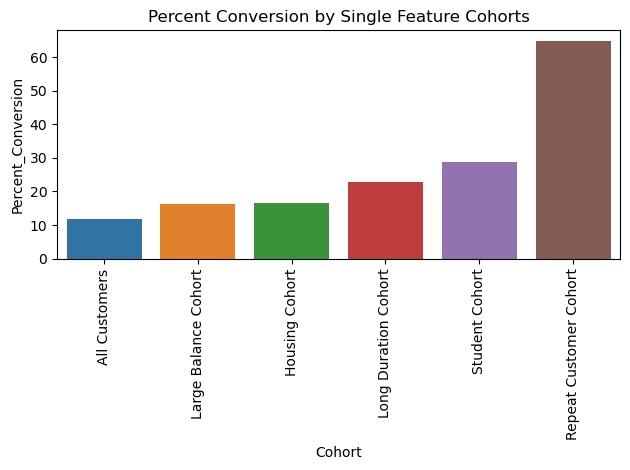

In [376]:
sns.barplot(data=single_results_df, x='Cohort',y='Percent_Conversion').set(title='Percent Conversion by Single Feature Cohorts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/var/local/data/bank_loan_predictor/images/Conversion_By_Cohort.jpg')
plt.show();

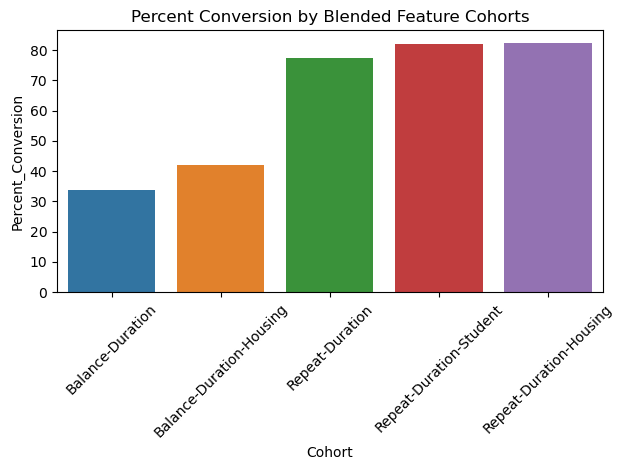

In [378]:
sns.barplot(data=blended_results_df, x='Cohort',y='Percent_Conversion').set(title='Percent Conversion by Blended Feature Cohorts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/var/local/data/bank_loan_predictor/images/Conversion_By_Blended_Cohort.jpg')
plt.show();

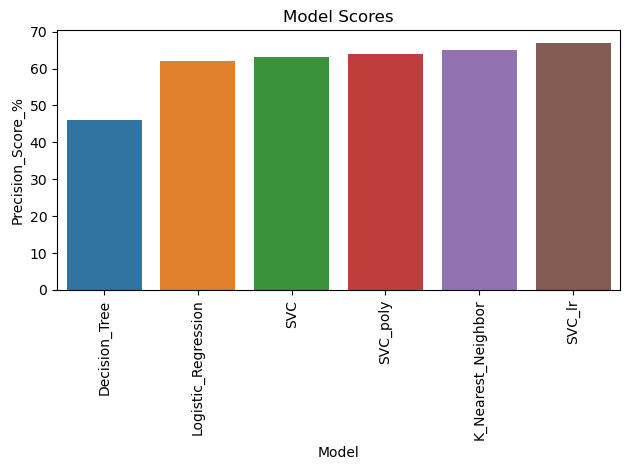

In [288]:
sns.barplot(data=df_precision,x='Model',y='Precision_Score_%').set(title="Model Scores")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/var/local/data/bank_loan_predictor/images/Model_Scores.jpg')
plt.show();

In [ ]:
##########  APPENDIX   ###########
#########   WARNING   ############
## LONG RUNNING PROCESSESS AHEAD!  ##
#########   WARNING   ############
##########  APPENDIX   ###########

In [381]:
# Build training and test datasets for previous outcome, modeling cohorts.  
# Compare model precision to manual stacking completed above
X_cohort_pcd=po_dur_stud_cohort_df.drop(['y','job'],axis=1)
y_cohort_pcd=po_dur_stud_cohort_df['y']
X_cohort_pcd_train, X_cohort_pcd_test, y_cohort_pcd_train, y_cohort_pcd_test = train_test_split(X_cohort, y_cohort, test_size=0.33, random_state=42)

In [382]:
# 83.1% percent precision as measured by model is very close to 82.1% as measured by manual predictions
%%time
pipe_dt_cohort=Pipeline([('scale',StandardScaler()),('dt',DecisionTreeClassifier())])
pipe_dt_cohort.fit(X_cohort_pcd_train,y_cohort_pcd_train)
preds_dt_cohort_pcd=pipe_dt_cohort.predict(X_cohort_pcd_test)
print(precision_score(y_cohort_pcd_test,preds_dt_cohort_pcd))

0.8319327731092437
CPU times: user 6.59 ms, sys: 1.38 ms, total: 7.97 ms
Wall time: 6.74 ms


In [268]:
#########   WARNING  >1 minute run time ############
#### UNCOMMENT TO RUN ########
### Sample Result Below
###: {'knn__n_neighbors': 5}

#%time
#k_range = list(range(2, 32,3))
##param_grid = dict(n_neighbors=k_range)
#parameters = {'knn__n_neighbors': k_range}

  
## defining parameter range
#grid = GridSearchCV(pipe_knn, parameters, scoring='precision', return_train_score=False,verbose=1)
  
## fitting the model for grid search
#grid_search=grid.fit(X_train, y_train)

## best value for k
#print('###:',grid_search.best_params_)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 31.9 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value N

###: {'knn__n_neighbors': 26}


/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [278]:
#########   WARNING  > 5 minute run time ############
#### UNCOMMENT TO RUN ########
### Sample Result Below
###: {'svc_lr__C': 5}

#%time
#c_range =[0.1,0.5,1.0,5] 
#parameters = {'svc_lr__C': c_range}

  
## defining parameter range
#grid_svc = GridSearchCV(pipe_svc_lr, parameters, scoring='precision', return_train_score=False,verbose=1)
  
##fitting the model for grid search
#grid_search_svc=grid_svc.fit(X_train, y_train)

## best value for k
#print('###:',grid_search_svc.best_params_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 9.06 µs
Fitting 5 folds for each of 4 candidates, totalling 20 fits
###: {'svc_lr__C': 5}
